In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import yfinance as yf
import statsmodels.formula.api as smf

2023-03-27 02:32:08.127751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
monthly_data = pd.read_csv('final_project_data.csv',parse_dates=True)
monthly_data.shape

(478, 8)

In [3]:
monthly_data.head()

,Unnamed: 0,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK
0,1983-02-01,8.54,11.3338,0.037076,0.049259,10.4,10.7,1.5115
1,1983-03-01,8.69,10.9757,0.034847,0.053428,10.4,10.8,1.4825
2,1983-04-01,8.63,10.2616,0.035903,0.046267,10.3,10.8,1.5573
3,1983-05-01,8.49,10.2593,0.040000,0.040038,10.2,11.0,1.6005
4,1983-06-01,9.20,9.9384,0.034411,0.036957,10.1,10.9,1.5330


In [4]:
monthly_data.reset_index(inplace=True)

In [5]:
monthly_data.drop(["index"], axis = 1, inplace = True)


In [6]:
monthly_data.rename(columns = {"Unnamed: 0": 'DATE'}, inplace = True)

In [7]:
monthly_data.head()

,DATE,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK
0,1983-02-01,8.54,11.3338,0.037076,0.049259,10.4,10.7,1.5115
1,1983-03-01,8.69,10.9757,0.034847,0.053428,10.4,10.8,1.4825
2,1983-04-01,8.63,10.2616,0.035903,0.046267,10.3,10.8,1.5573
3,1983-05-01,8.49,10.2593,0.040000,0.040038,10.2,11.0,1.6005
4,1983-06-01,9.20,9.9384,0.034411,0.036957,10.1,10.9,1.5330


<AxesSubplot:xlabel='DATE'>

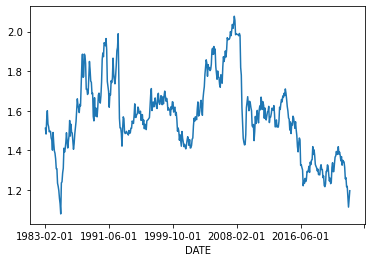

In [8]:
df_fx = monthly_data.set_index('DATE')
df_fx['DEXUSUK'].plot()

Training dataset: 442, Test dataset: 36


Text(0.5, 0, '1983-02-01')

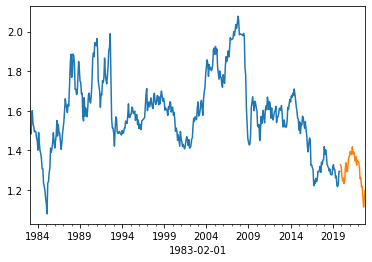

In [9]:
# Convert index to datetime format
df_fx.index = pd.to_datetime(df_fx.index)

split_point = len(df_fx) - 36
train, val = df_fx[0:split_point], df_fx[split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(val)))
ax = train['DEXUSUK'].plot()

# Convert index of validation set to datetime format and shift
val.index = pd.to_datetime(val.index)
val['DEXUSUK'].plot(ax=ax)

ax.set_xlabel(train.index[0].strftime('%Y-%m-%d'))


In [10]:
print("Train Data Shape: ", train.shape)
print("TestData Shape: ",val.shape)

Train Data Shape:  (442, 7)
TestData Shape:  (36, 7)


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)

In [12]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled_df.head(5)

,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK
DATE,,,,,,,
1983-02-01,0.736245,0.736103,0.679558,0.522298,1.000000,0.921053,0.433063
1983-03-01,0.749345,0.712191,0.652821,0.568363,1.000000,0.934211,0.404025
1983-04-01,0.744105,0.664508,0.665485,0.489225,0.985507,0.934211,0.478923
1983-05-01,0.731878,0.664354,0.714621,0.420384,0.971014,0.960526,0.522179
1983-06-01,0.793886,0.642926,0.647592,0.386335,0.956522,0.947368,0.454591


In [13]:
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)
val_scaled_df.head(5)

,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK
DATE,,,,,,,
2019-12-01,0.144105,0.032051,0.482226,0.143326,0.000000,0.000000,0.248223
2020-01-01,0.134498,0.028713,0.512422,0.122380,0.000000,0.000000,0.240813
2020-02-01,0.129258,0.029381,0.534779,0.175263,0.014493,0.013158,0.199059
2020-03-01,0.108297,0.014690,0.515459,0.164177,0.000000,0.013158,0.166617
2020-04-01,0.108297,0.022703,0.419943,0.143172,0.130435,0.013158,0.181436


In [14]:
print("Train:   ", train_scaled_df.index.min(),"   :   ", train_scaled_df.index.max())
print("Val:   ", val_scaled_df.index.min(),"   :   ", val_scaled_df.index.max())

train_date_min = train_scaled_df.index.min()
train_date_max = train_scaled_df.index.max()
val_date_min = val_scaled_df.index.min()
val_date_max = val_scaled_df.index.max()

Train:    1983-02-01 00:00:00    :    2019-11-01 00:00:00
Val:    2019-12-01 00:00:00    :    2022-11-01 00:00:00


In [15]:
# Let us setup the context window and forecast horizon
# Let us say we want to look at the past 6 months to predict the next 1 months

context_window = 6
forecast_horizon = 1

In [16]:
def data_prep_time_series(data, context_window, forecast_horizon):
    X, y = list(), list()    
    
    for i in range(len(data)):
        #find end of pattern
        end_ix = i + context_window
        out_end_ix = end_ix + forecast_horizon - 1
        
        #check if we are beyond the dataset
        if out_end_ix > len(data):
            break
        
        #gather input and output
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [17]:
train_in_usinterest = np.array(train_scaled_df['United States Interest'])
train_in_ukinterest = np.array(train_scaled_df['United Kingdom Interest'])
train_in_usinflation = np.array(train_scaled_df['United States Inflation'])
train_in_ukinflation = np.array(train_scaled_df['United Kingdom Inflation'])
train_in_usunemploy = np.array(train_scaled_df['United States Unemployment'])
train_in_ukunemploy = np.array(train_scaled_df['United Kingdom Unemployment'])
train_in_dexusuk = np.array(train_scaled_df['DEXUSUK'])

train_in_usinterest = train_in_usinterest.reshape((len(train_in_usinterest),1))
train_in_ukinterest = train_in_ukinterest.reshape((len(train_in_ukinterest),1))
train_in_usinflation = train_in_usinflation.reshape((len(train_in_usinflation),1))
train_in_ukinflation = train_in_ukinflation.reshape((len(train_in_ukinflation),1))
train_in_usunemploy = train_in_usunemploy.reshape((len(train_in_usunemploy),1))
train_in_ukunemploy = train_in_ukunemploy.reshape((len(train_in_ukunemploy),1))
train_in_dexusuk = train_in_dexusuk.reshape((len(train_in_dexusuk),1))

trainoutput_dexusuk = train_in_dexusuk
trainset = np.hstack((train_in_dexusuk,train_in_usinterest,train_in_ukinterest,train_in_usinflation,
                      train_in_ukinflation,train_in_usunemploy,trainoutput_dexusuk))

In [18]:
test_usinterest = np.array(val_scaled_df['United States Interest'])
test_ukinterest = np.array(val_scaled_df['United Kingdom Interest'])
test_usinflation = np.array(val_scaled_df['United States Inflation'])
test_ukinflation = np.array(val_scaled_df['United Kingdom Inflation'])
test_usunemploy = np.array(val_scaled_df['United States Unemployment'])
test_ukunemploy = np.array(val_scaled_df['United Kingdom Unemployment'])
test_dexusuk = np.array(val_scaled_df['DEXUSUK'])

test_usinterest = test_usinterest.reshape((len(test_usinterest),1))
test_ukinterest = test_ukinterest.reshape((len(test_ukinterest),1))
test_usinflation = test_usinflation.reshape((len(test_usinflation),1))
test_ukinflation = test_ukinflation.reshape((len(test_ukinflation),1))
test_usunemploy = test_usunemploy.reshape((len(test_usunemploy),1))
test_ukunemploy = test_ukunemploy.reshape((len(test_ukunemploy),1))
test_dexusuk = test_dexusuk.reshape((len(test_dexusuk),1))

testoutput_dexusuk = test_dexusuk
testset = np.hstack((test_dexusuk,test_usinterest,test_ukinterest,test_usinflation,
                      test_ukinflation,test_usunemploy,testoutput_dexusuk))

In [19]:
trainX, trainy = data_prep_time_series(trainset, context_window, forecast_horizon)

testX, testy = data_prep_time_series(testset, context_window, forecast_horizon)

print(trainX.shape, trainy.shape)
print(testX.shape, testy.shape)


(437, 6, 6) (437, 1)
(31, 6, 6) (31, 1)


2023-03-27 02:32:29.900318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


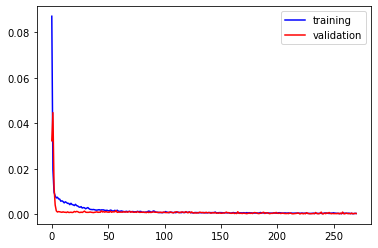

In [20]:
n_features = trainX.shape[2]

multi_model = Sequential()

# Adding the LSTM layer and dropout regularizaiton
multi_model.add(LSTM(100, return_sequences = True, input_shape=(context_window, n_features)))
multi_model.add(LSTM(100))
multi_model.add(Dropout(0.2))

# Adding output layer
multi_model.add(Dense(forecast_horizon))

multi_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error')

earlystop = EarlyStopping(monitor = 'val_loss', patience =50,
                  mode = 'min',
                  verbose = 0)

fit = multi_model.fit(trainX, 
          trainy, validation_data = (testX, testy),   
          epochs = 500, verbose=0, callbacks = [earlystop])


# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show()

In [21]:
testPredict = multi_model.predict(testX)

1/1 [==============================] - 1s 804ms/step


In [22]:
testX.shape

(31, 6, 6)

In [23]:
testX_new = testX.reshape((testX.shape[0], testX.shape[2]*testX.shape[1]))
print(testX_new.shape)

# Invert scaling for Predicted
testY_hat = np.concatenate((testX_new[:, 1:7], testPredict), axis=1)
print(testY_hat.shape)

testY_hat = scaler.inverse_transform(testY_hat)

(31, 36)
(31, 7)


In [24]:
print(testY_hat.shape)

(31, 7)


In [25]:
testY_hat = testY_hat[:,6]

# Invert scaling for Actual
testY_actual = np.concatenate((testX_new[:,1:7], testy), axis=1)
testY_actual = scaler.inverse_transform(testY_actual)

testY_actual = testY_actual[:,6]

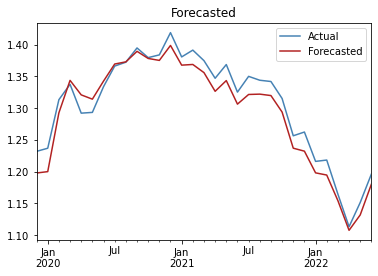

In [26]:
fig, ax = plt.subplots()
observed = pd.DataFrame(testY_actual)
predicted = pd.DataFrame(testY_hat, index=pd.date_range('2019-12-01',periods=31,freq='M'))
observed.index = predicted.index
observed.plot(color = 'SteelBlue',  title = "Actual",legend = True, label="Actual",ax=ax)
predicted.plot(color = 'Firebrick',title="Forecasted", legend = True, label="Forecasted",ax=ax)
ax.legend(["Actual", "Forecasted"])
plt.show()

In [27]:
predicted.rename(columns = {0: "DEXUSUK"}, inplace = True)

In [28]:
predicted.index.name = "Date"

In [29]:
observed.rename(columns = {0: "DEXUSUK"}, inplace = True)
observed.index.name = "Date"

In [30]:
# Define the hyperparameter z
z = 0.00

# Calculate the percentage change in the forecast column
predicted['pct_change'] = predicted['DEXUSUK'].pct_change()

# Generate the trading signal based on the percentage change
predicted['signal'] = np.where(predicted['pct_change'] > z, 1, 
                                 np.where(predicted['pct_change'] < -z, -1, 0))

# Remove the first row, which has a NaN value for the percentage change
predicted = predicted.iloc[1:]

In [89]:
observed['pct_change'] = observed['DEXUSUK'].pct_change()
observed['signal'] = predicted['signal'].shift(-1) 
#Signal is moved back for the plot to show we enter signaled position at time t based on the forecasted sign of t+1
observed['monthly_returns'] = observed['pct_change']*observed['signal'].shift()
#Signal is shifted back up because we match the sign of the returns with the sign of the signal we traded last period
observed['monthly_log_returns'] = np.log(observed['monthly_returns']+1)
observed['cumulative_returns'] = np.exp((observed['monthly_log_returns']).cumsum())-1


In [79]:
observed.head()

,DEXUSUK,pct_change,signal,monthly_log_returns,cumulative_returns,forecasted_pct_change,forecasted_exr,monthly_simple_returns
Date,,,,,,,,
2019-12-31,1.2320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,1.2369,0.003977,1.0,NaN,NaN,0.001812,1.200082,1.003977
2020-02-29,1.3133,0.061767,1.0,0.059935,0.061767,0.077123,1.292635,1.061767
2020-03-31,1.3375,0.018427,-1.0,0.018259,1.080194,0.039512,1.343710,1.018427
2020-04-30,1.2921,-0.033944,-1.0,0.033381,2.114138,-0.016998,1.320870,0.966056


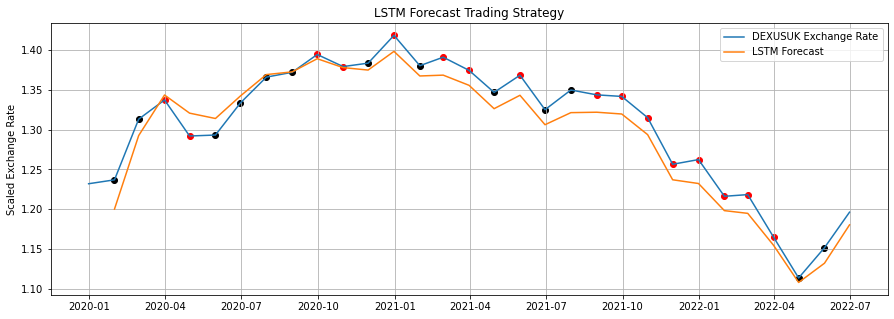

In [74]:
#interest2 = interest2[interest2.index.year >= 2017]
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title('LSTM Forecast Trading Strategy')

ax.set_ylabel("Scaled Exchange Rate")
ax.plot(observed['DEXUSUK'])
ax.plot(predicted['DEXUSUK'])



ax.scatter(observed[observed.signal == 1].index, observed[observed.signal == 1]["DEXUSUK"], color = "black")
ax.scatter(observed[observed.signal == -1].index, observed[observed.signal == -1]["DEXUSUK"], color = "red")

ax.legend(["DEXUSUK Exchange Rate", "LSTM Forecast"])


#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
ax.grid()

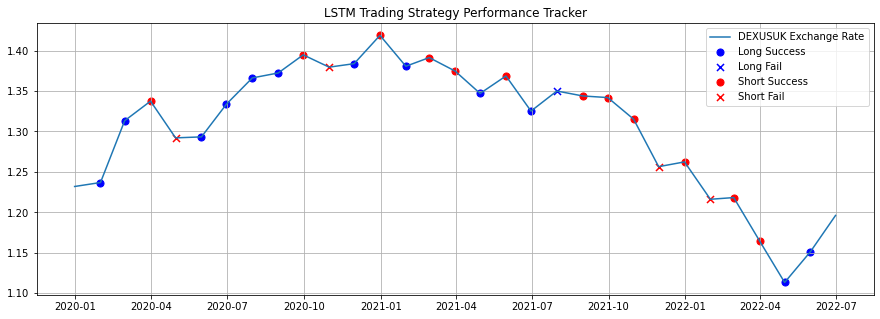

In [75]:
plt.figure(figsize = (15, 5))

plt.title('LSTM Trading Strategy Performance Tracker')

plt.plot(observed['DEXUSUK'])

longsuccess = observed[(observed['pct_change'].shift(-1)>0) & (observed["signal"] == 1)]
longfail = observed[(observed['pct_change'].shift(-1)<0) & (observed["signal"] == 1)] 
shortsuccess = observed[(observed['pct_change'].shift(-1)<0) & (observed["signal"] == -1)]
shortfail = observed[(observed['pct_change'].shift(-1)>0) & (observed["signal"] == -1)]

plt.scatter(longsuccess.index, longsuccess["DEXUSUK"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["DEXUSUK"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["DEXUSUK"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["DEXUSUK"], color = 'red', s = 50, marker = "x")

plt.legend(["DEXUSUK Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

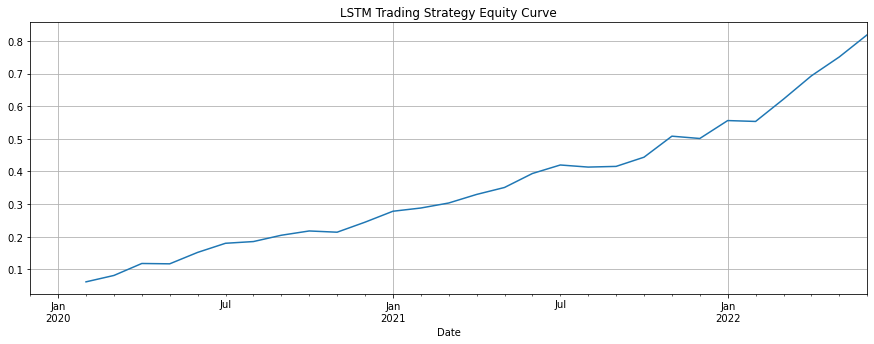

In [90]:
plt.figure(figsize = (15, 5))
observed['cumulative_returns'].plot()
plt.title('LSTM Trading Strategy Equity Curve')
plt.grid()

In [87]:
observed

,DEXUSUK,pct_change,signal,monthly_log_returns,cumulative_returns,forecasted_pct_change,forecasted_exr,monthly_simple_returns
Date,,,,,,,,
2019-12-31,1.2320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,1.2369,0.003977,1.0,NaN,NaN,0.001812,1.200082,NaN
2020-02-29,1.3133,0.061767,1.0,0.059935,0.061767,0.077123,1.292635,0.061767
2020-03-31,1.3375,0.018427,-1.0,0.018259,0.081332,0.039512,1.343710,0.018427
2020-04-30,1.2921,-0.033944,-1.0,0.033381,0.118037,-0.016998,1.320870,0.033944
2020-05-31,1.2933,0.000929,1.0,-0.000929,0.116999,-0.005102,1.314131,-0.000929
2020-06-30,1.3338,0.031315,1.0,0.030835,0.151978,0.021629,1.342554,0.031315
2020-07-31,1.3662,0.024291,1.0,0.024001,0.179961,0.020006,1.369413,0.024291
2020-08-31,1.3723,0.004465,1.0,0.004455,0.185229,0.002491,1.372824,0.004465


**Geometric Monthly Average**

In [91]:
# Calculate geometric monthly average returns
geometric_mean = (1 + df_copy['pct_change']).prod() ** (1 / len(df_copy)) - 1
print("Geometric Mean:", geometric_mean)

Geometric Mean: -0.0009508057453323504


**Standard Deviatioin**

In [92]:
df_copy['monthly_returns'].std()

0.01735516046674129

**High Month**

In [93]:
print('High Month:', df_copy['monthly_returns'].max())

High Month: 0.06176732152963038


**Low Month**

In [94]:
print('High Month:', df_copy['monthly_returns'].min())

High Month: -0.004695582968563539


**Total Return**

In [95]:
totalReturn = float(df_copy['cumulative_returns'].iloc[-1:])
print( str(totalReturn) + '%')

0.8190485368211404%


**Annualized**

In [96]:
# Calculate the number of months
num_months = len(df_copy['cumulative_returns'])

# Calculate the total return over the period
total_return = df_copy['cumulative_returns'][-1]

# Calculate the annualized return
annualized_return = ((1 + total_return) ** (12 / num_months)) - 1

print(f"Annualized return: {annualized_return:.2%}")


Annualized return: 26.06%


**Annualized Returns Standard Deviation**

In [97]:
monthly_std = df_copy['monthly_returns'].std()
annualized_std = monthly_std * np.sqrt(12)
print('Annualized Returns Standard Deviation:', annualized_std)

Annualized Returns Standard Deviation: 0.060120039403813406


**Risk Free Rate**

In [98]:
treasury = pd.read_csv('1-year-treasury-rate-yield-chart.csv', index_col=0, parse_dates=True).dropna()
df_copy['Risk Free'] = treasury
df_copy = df_copy.ffill()
df_copy['Returns Percent'] = df_copy['monthly_returns']*100
df_copy

,DEXUSUK,pct_change,signal,monthly_log_returns,cumulative_returns,forecasted_pct_change,forecasted_exr,monthly_simple_returns,monthly_returns,Risk Free,Returns Percent
Date,,,,,,,,,,,
2019-12-31,1.2320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.59,NaN
2020-01-31,1.2369,0.003977,1.0,NaN,NaN,0.001812,1.200082,NaN,NaN,1.45,NaN
2020-02-29,1.3133,0.061767,1.0,0.059935,0.061767,0.077123,1.292635,0.061767,0.061767,1.45,6.176732
2020-03-31,1.3375,0.018427,-1.0,0.018259,0.081332,0.039512,1.343710,0.018427,0.018427,0.17,1.842686
2020-04-30,1.2921,-0.033944,-1.0,0.033381,0.118037,-0.016998,1.320870,0.033944,0.033944,0.16,3.394393
2020-05-31,1.2933,0.000929,1.0,-0.000929,0.116999,-0.005102,1.314131,-0.000929,-0.000929,0.16,-0.092872
2020-06-30,1.3338,0.031315,1.0,0.030835,0.151978,0.021629,1.342554,0.031315,0.031315,0.16,3.131524
2020-07-31,1.3662,0.024291,1.0,0.024001,0.179961,0.020006,1.369413,0.024291,0.024291,0.11,2.429150
2020-08-31,1.3723,0.004465,1.0,0.004455,0.185229,0.002491,1.372824,0.004465,0.004465,0.12,0.446494


In [99]:
df_copy['Risk Free'].mean()

0.5529032258064517

**Sharpe Ratio**

In [100]:
excessReturns = df_copy['Returns Percent'] - df_copy['Risk Free']
sharpeRatio = excessReturns.mean() / excessReturns.std()
print('Sharpe Ratio: ' + str(sharpeRatio))

Sharpe Ratio: 1.0842137331326318


**% of Winning Months**

In [101]:
winning_months = df_copy[df_copy['monthly_returns'] > 0].count()
total_months = df_copy['monthly_returns'].count()
winning_percentage = (winning_months/total_months) * 100
print('% of Winning Months:', winning_percentage['monthly_returns'])

% of Winning Months: 82.75862068965517


**Max Drawdown**

In [102]:
df_copy['Cumulative Max'] = df_copy['cumulative_returns'].cummax()
df_copy['Drawdown'] = df_copy['Cumulative Max'] - df_copy['cumulative_returns']
print('Max Drawdown:', df_copy['Drawdown'].max())

Max Drawdown: 0.007081865605534254


**Regression**

In [103]:
data = yf.download("^GSPC", start="2019-12-31", end="2022-11-02", interval="1d")
data.index = data.index.strftime('%Y-%m-%d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,3230.780029,2894760000
2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000
...,...,...,...,...,...,...
2022-10-26,3825.969971,3886.149902,3824.070068,3830.600098,3830.600098,4817310000
2022-10-27,3834.689941,3859.949951,3803.790039,3807.300049,3807.300049,4687320000
2022-10-28,3808.260010,3905.419922,3808.260010,3901.060059,3901.060059,4459410000


In [104]:
data["marketPercent"] = np.log(data["Adj Close"]).diff()
data = data.iloc[1:, :]
reg = df_copy.copy()
reg.index = reg.index.strftime('%Y-%m-%d')
# Set the index of the SP500 data to a datetime index
data.index = pd.to_datetime(data.index)

# Reindex the SP500 data to match the index of the reg data
data = data.reindex(reg.index, method='ffill')

# Combine the data
reg['marketPercent'] = data['marketPercent']
reg

,DEXUSUK,pct_change,signal,monthly_log_returns,cumulative_returns,forecasted_pct_change,forecasted_exr,monthly_simple_returns,monthly_returns,Risk Free,Returns Percent,Cumulative Max,Drawdown,marketPercent
Date,,,,,,,,,,,,,,
2019-12-31,1.2320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.59,NaN,NaN,NaN,NaN
2020-01-31,1.2369,0.003977,1.0,NaN,NaN,0.001812,1.200082,NaN,NaN,1.45,NaN,NaN,NaN,-0.017864
2020-02-29,1.3133,0.061767,1.0,0.059935,0.061767,0.077123,1.292635,0.061767,0.061767,1.45,6.176732,0.061767,0.000000,-0.008272
2020-03-31,1.3375,0.018427,-1.0,0.018259,0.081332,0.039512,1.343710,0.018427,0.018427,0.17,1.842686,0.081332,0.000000,-0.016142
2020-04-30,1.2921,-0.033944,-1.0,0.033381,0.118037,-0.016998,1.320870,0.033944,0.033944,0.16,3.394393,0.118037,0.000000,-0.009255
2020-05-31,1.2933,0.000929,1.0,-0.000929,0.116999,-0.005102,1.314131,-0.000929,-0.000929,0.16,-0.092872,0.118037,0.001038,0.004801
2020-06-30,1.3338,0.031315,1.0,0.030835,0.151978,0.021629,1.342554,0.031315,0.031315,0.16,3.131524,0.151978,0.000000,0.015292
2020-07-31,1.3662,0.024291,1.0,0.024001,0.179961,0.020006,1.369413,0.024291,0.024291,0.11,2.429150,0.179961,0.000000,0.007641
2020-08-31,1.3723,0.004465,1.0,0.004455,0.185229,0.002491,1.372824,0.004465,0.004465,0.12,0.446494,0.185229,0.000000,-0.002197


In [105]:
reg['excessReturns'] = reg['Returns Percent'] - reg['Risk Free']
reg['marketExcessReturns'] = reg['marketPercent'] - reg['Risk Free']
reg

,DEXUSUK,pct_change,signal,monthly_log_returns,cumulative_returns,forecasted_pct_change,forecasted_exr,monthly_simple_returns,monthly_returns,Risk Free,Returns Percent,Cumulative Max,Drawdown,marketPercent,excessReturns,marketExcessReturns
Date,,,,,,,,,,,,,,,,
2019-12-31,1.2320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.59,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,1.2369,0.003977,1.0,NaN,NaN,0.001812,1.200082,NaN,NaN,1.45,NaN,NaN,NaN,-0.017864,NaN,-1.467864
2020-02-29,1.3133,0.061767,1.0,0.059935,0.061767,0.077123,1.292635,0.061767,0.061767,1.45,6.176732,0.061767,0.000000,-0.008272,4.726732,-1.458272
2020-03-31,1.3375,0.018427,-1.0,0.018259,0.081332,0.039512,1.343710,0.018427,0.018427,0.17,1.842686,0.081332,0.000000,-0.016142,1.672686,-0.186142
2020-04-30,1.2921,-0.033944,-1.0,0.033381,0.118037,-0.016998,1.320870,0.033944,0.033944,0.16,3.394393,0.118037,0.000000,-0.009255,3.234393,-0.169255
2020-05-31,1.2933,0.000929,1.0,-0.000929,0.116999,-0.005102,1.314131,-0.000929,-0.000929,0.16,-0.092872,0.118037,0.001038,0.004801,-0.252872,-0.155199
2020-06-30,1.3338,0.031315,1.0,0.030835,0.151978,0.021629,1.342554,0.031315,0.031315,0.16,3.131524,0.151978,0.000000,0.015292,2.971524,-0.144708
2020-07-31,1.3662,0.024291,1.0,0.024001,0.179961,0.020006,1.369413,0.024291,0.024291,0.11,2.429150,0.179961,0.000000,0.007641,2.319150,-0.102359
2020-08-31,1.3723,0.004465,1.0,0.004455,0.185229,0.002491,1.372824,0.004465,0.004465,0.12,0.446494,0.185229,0.000000,-0.002197,0.326494,-0.122197


In [106]:
results = smf.ols('excessReturns ~ marketExcessReturns', data = reg).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excessReturns   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.4407
Date:                Mon, 27 Mar 2023   Prob (F-statistic):              0.512
Time:                        03:34:27   Log-Likelihood:                -51.918
No. Observations:                  29   AIC:                             107.8
Df Residuals:                      27   BIC:                             110.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.4861      0.338      4.398      0.000       0.793       2.179
marketExcessReturns    -0.2579      0.388     -0.664      0.512      -1.055       0.539
==============================================================================
Omnibus:                        0.377   Durbin-Watson:                   2.383
Prob(Omnibus):                  0.828   Jarque-Bera (JB):                0.530
Skew:                          -0.091   Prob(JB):                        0.767
Kurtosis:                       2.363   Cond. No.                         1.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Alpha**

In [107]:
# extract alpha and beta coefficients
alpha = results.params[0]

print('Alpha: {:.4f}'.format(alpha))

Alpha: 1.4861


**Beta**

In [109]:
beta = results.params[1]

print('Beta: {:.4f}'.format(beta))

Beta: -0.2579


**R-Squared**

In [110]:
# print R-squared
print('R-squared: {:.4f}'.format(results.rsquared))

R-squared: 0.0161


**Correlation**

In [111]:
# calculate correlation
corr = reg['excessReturns'].corr(reg['marketExcessReturns'])

# print correlation
print('Correlation: {:.4f}'.format(corr))

Correlation: -0.1267


**Up Alpha**

In [112]:
df_above_zero = reg.loc[reg['marketPercent'] > 0]
df_above_zero

,DEXUSUK,pct_change,signal,monthly_log_returns,cumulative_returns,forecasted_pct_change,forecasted_exr,monthly_simple_returns,monthly_returns,Risk Free,Returns Percent,Cumulative Max,Drawdown,marketPercent,excessReturns,marketExcessReturns
Date,,,,,,,,,,,,,,,,
2020-05-31,1.2933,0.000929,1.0,-0.000929,0.116999,-0.005102,1.314131,-0.000929,-0.000929,0.16,-0.092872,0.118037,0.001038,0.004801,-0.252872,-0.155199
2020-06-30,1.3338,0.031315,1.0,0.030835,0.151978,0.021629,1.342554,0.031315,0.031315,0.16,3.131524,0.151978,0.000000,0.015292,2.971524,-0.144708
2020-07-31,1.3662,0.024291,1.0,0.024001,0.179961,0.020006,1.369413,0.024291,0.024291,0.11,2.429150,0.179961,0.000000,0.007641,2.319150,-0.102359
2020-09-30,1.3947,0.016323,-1.0,0.016191,0.204576,0.012073,1.389399,0.016323,0.016323,0.12,1.632296,0.204576,0.000000,0.008220,1.512296,-0.111780
2020-12-31,1.4188,0.025293,-1.0,0.024978,0.244611,0.017118,1.398646,0.025293,0.025293,0.10,2.529267,0.244611,0.000000,0.006418,2.429267,-0.093582
2021-03-31,1.3747,-0.011931,-1.0,0.011861,0.303395,-0.009375,1.355884,0.011931,0.011931,0.07,1.193129,0.303395,0.000000,0.003616,1.123129,-0.066384
2021-05-31,1.3686,0.016036,-1.0,0.015908,0.350980,0.012719,1.343356,0.016036,0.016036,0.05,1.603563,0.350980,0.000000,0.000769,1.553563,-0.049231
2021-06-30,1.3252,-0.031711,1.0,0.031219,0.393821,-0.027583,1.306302,0.031711,0.031711,0.07,3.171124,0.393821,0.000000,0.001327,3.101124,-0.068673
2021-10-31,1.3152,-0.019897,-1.0,0.019702,0.443759,-0.019676,1.293815,0.019897,0.019897,0.09,1.989716,0.443759,0.000000,0.001947,1.899716,-0.088053


In [113]:
resultsUp = smf.ols('excessReturns ~ marketExcessReturns', data = df_above_zero).fit()
resultsUp.summary()

/Users/Cade/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excessReturns   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.6591
Date:                Mon, 27 Mar 2023   Prob (F-statistic):              0.440
Time:                        03:34:51   Log-Likelihood:                -13.530
No. Observations:                  10   AIC:                             31.06
Df Residuals:                       8   BIC:                             31.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.7348      0.427      4.064      0.004       0.751       2.719
marketExcessReturns    -1.3332      1.642     -0.812      0.440      -5.120       2.454
==============================================================================
Omnibus:                        4.515   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                1.527
Skew:                          -0.913   Prob(JB):                        0.466
Kurtosis:                       3.572   Cond. No.                         5.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
# extract alpha and beta coefficients
alphaUp = resultsUp.params[0]

print('Alpha: {:.4f}'.format(alphaUp))

Alpha: 1.7348


**Up Beta**

In [115]:
betaUp = resultsUp.params[1]

print('Beta: {:.4f}'.format(betaUp))

Beta: -1.3332


**Down Alpha**

In [116]:
df_below_zero = reg.loc[reg['marketPercent'] < 0]
df_below_zero

,DEXUSUK,pct_change,signal,monthly_log_returns,cumulative_returns,forecasted_pct_change,forecasted_exr,monthly_simple_returns,monthly_returns,Risk Free,Returns Percent,Cumulative Max,Drawdown,marketPercent,excessReturns,marketExcessReturns
Date,,,,,,,,,,,,,,,,
2020-01-31,1.2369,0.003977,1.0,NaN,NaN,0.001812,1.200082,NaN,NaN,1.45,NaN,NaN,NaN,-0.017864,NaN,-1.467864
2020-02-29,1.3133,0.061767,1.0,0.059935,0.061767,0.077123,1.292635,0.061767,0.061767,1.45,6.176732,0.061767,0.000000,-0.008272,4.726732,-1.458272
2020-03-31,1.3375,0.018427,-1.0,0.018259,0.081332,0.039512,1.343710,0.018427,0.018427,0.17,1.842686,0.081332,0.000000,-0.016142,1.672686,-0.186142
2020-04-30,1.2921,-0.033944,-1.0,0.033381,0.118037,-0.016998,1.320870,0.033944,0.033944,0.16,3.394393,0.118037,0.000000,-0.009255,3.234393,-0.169255
2020-08-31,1.3723,0.004465,1.0,0.004455,0.185229,0.002491,1.372824,0.004465,0.004465,0.12,0.446494,0.185229,0.000000,-0.002197,0.326494,-0.122197
2020-10-31,1.3795,-0.010898,-1.0,0.010839,0.217704,-0.008071,1.378185,0.010898,0.010898,0.12,1.089840,0.217704,0.000000,-0.012204,0.969840,-0.132204
2020-11-30,1.3838,0.003117,1.0,-0.003122,0.213908,-0.002233,1.375106,-0.003117,-0.003117,0.11,-0.311707,0.217704,0.003796,-0.004606,-0.421707,-0.114606
2021-01-31,1.3806,-0.026924,1.0,0.026568,0.278121,-0.022153,1.367661,0.026924,0.026924,0.10,2.692416,0.278121,0.000000,-0.019500,2.592416,-0.119500
2021-02-28,1.3913,0.007750,-1.0,0.007720,0.288027,0.000771,1.368716,0.007750,0.007750,0.10,0.775025,0.288027,0.000000,-0.004762,0.675025,-0.104762


In [117]:
resultsDown = smf.ols('excessReturns ~ marketExcessReturns', data = df_below_zero).fit()
resultsDown.summary()

/Users/Cade/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=19



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excessReturns   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.6789
Date:                Mon, 27 Mar 2023   Prob (F-statistic):              0.421
Time:                        03:35:05   Log-Likelihood:                -35.908
No. Observations:                  19   AIC:                             75.82
Df Residuals:                      17   BIC:                             77.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.1760      0.498      2.361      0.030       0.125       2.227
marketExcessReturns    -0.3880      0.471     -0.824      0.421      -1.382       0.606
==============================================================================
Omnibus:                        0.652   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.722   Jarque-Bera (JB):                0.689
Skew:                           0.255   Prob(JB):                        0.708
Kurtosis:                       2.218   Cond. No.                         2.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
# extract alpha and beta coefficients
alphaDown = resultsDown.params[0]

print('Alpha: {:.4f}'.format(alphaDown))

Alpha: 1.1760


**Down Beta**

In [119]:
betaDown = resultsDown.params[1]

print('Beta: {:.4f}'.format(betaDown))

Beta: -0.3880
